In [27]:
import os
import pandas as pd
import jieba
jieba.set_dictionary('dict.txt.big')
with open('stops.txt', 'r', encoding='utf8') as f:
    stops = f.read().split('\n')
    
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

# from datetime import datetime
# starttime= datetime.now()

# LoadData

In [12]:
files = [os.path.join('articles', i) for i in os.listdir("articles")]

df = pd.DataFrame()
for f in files:
    df_part = pd.read_csv(f)
    df = pd.concat([df, df_part], ignore_index=True)

df["publish_datetime"] = df["publish_datetime"].apply(pd.to_datetime)
df["crawled_date"] = df["crawled_date"].apply(pd.to_datetime)

for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
    df.loc[pd.notnull(df[h]), h] = df.loc[pd.notnull(df[h]), h].apply(eval)

print(len(df))
print(datetime.now()-starttime)

42584
0:00:12.770318


In [13]:
le_group = LabelEncoder()
le_group.fit(df['group'])

le_corpus_day = LabelEncoder()
max_corpus_day = df['corpus_day'].max()
le_corpus_day.fit(df['corpus_day'])

mlb = MultiLabelBinarizer()
term_idx_mapping = {}

def preprocess(df, train=True):
    df.fillna('None', inplace=True)
    df[df['corpus_day'] > max_corpus_day] = max_corpus_day  ## for testing purpose

    def preprocess_applyfun(row):
        # combine all headers
        header = ""
        for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
            if row[h] != "None":
                header += " ".join(row[h]) + "\n"

        # Tokenize
        row['article_title'] = [w for w in jieba.cut(row['article_title'], cut_all=True)]
        row['corpus_title'] = [w for w in jieba.cut(row['corpus_title'], cut_all=True)]
        row['header'] = [w for w in jieba.cut(header, cut_all=True)]
        row['text_content'] = [w for w in jieba.cut(row['text_content'], cut_all=True) if w not in stops]
        # cal_publish_hours
        timedelta = row['crawled_date'] - row['publish_datetime']
        row['publish_hours'] = timedelta.days * 24 + timedelta.seconds // 3600
        # group and corpus_day categorilize
        row['group'] = le_group.transform([row['group']])[0]
        row['corpus_day'] = le_corpus_day.transform([row['corpus_day']])[0]

        return row
    df = df.apply(preprocess_applyfun, axis=1)

    if train:
        mlb.fit(np.hstack([df['article_title'], df['corpus_title'], df['header'], df['text_content']]))
        for idx, term in enumerate(mlb.classes_):
            term_idx_mapping[term] = idx
            
    # Serialize tokens
    def getidxs(terms):
        idxs = []
        for term in terms:
            if term in term_idx_mapping.keys():
                idx = term_idx_mapping.get(term)
                idxs.append(idx)
        return idxs
    df['article_title'] = df['article_title'].apply(getidxs)
    df['corpus_title'] = df['corpus_title'].apply(getidxs)
    df['header'] = df['header'].apply(getidxs)
    df['text_content'] = df['text_content'].apply(getidxs)
    return df

df = preprocess(df)
print(datetime.now()-starttime)
df[['group', 'corpus_title', 'corpus_day', 'article_title', 'browse_count',
     'text_content', 'header', 'publish_hours']]

Building prefix dict from D:\Projects\ithome_ironman\day30_ithome_articles_pred\dict.txt.big ...
Loading model from cache C:\Users\Jeremy\AppData\Local\Temp\jieba.u611bbb79df8f1b83d7be7dc714cf7403.cache
Loading model cost 3.514 seconds.
Prefix dict has been built succesfully.


0:13:51.516443


,group,corpus_title,corpus_day,article_title,browse_count,text_content,header,publish_hours
0,3,"[14583, 26354, 43273, 38775, 58188]",14,"[14592, 43273, 38775, 0, 9742, 16253, 0, 51577...",3,[14735],"[39947, 65576, 41274, 0, 0, 37426, 39948, 1]",0
1,5,"[36748, 39072, 0, 0, 48580, 37350, 57149, 5715...",13,"[5166, 0, 41549, 41550, 53973, 56144, 66366, 6...",5,"[57793, 46794, 61064, 14872, 65228, 43403, 388...","[4850, 0, 33272, 18424, 15457, 5379, 0, 18424,...",0
2,5,"[58031, 67292, 56144, 15206, 13290, 45400, 608...",7,"[57521, 6380, 43273, 0, 0, 44228, 11641, 54298...",3,"[44896, 11077, 33638, 65794, 54298, 54299, 535...","[44228, 0, 11632, 8620, 0, 44285, 64831, 38420...",0
3,2,"[15022, 44138, 60060, 36047, 58188]",2,"[9395, 42358, 51644, 40051, 36047]",2,"[43640, 61580, 54772, 57795, 1, 51936, 62724, ...",[],0
4,3,"[43757, 36435, 39051, 39052, 65454, 53637, 350...",14,"[16309, 18629]",4,"[34665, 43432, 37026, 61644, 7916, 45412, 5629...",[],0
5,1,"[11913, 45412, 58011, 0, 0, 44228, 49924, 6006...",14,"[9737, 11788, 45412, 36047]",4,"[39075, 36047, 58001, 49075, 11783, 37666, 170...","[7181, 15529, 11951, 11783, 8675]",0
6,0,"[38884, 13745, 60060, 8788, 46195, 59967, 5097...",14,"[5199, 8788, 0, 50268, 59269, 51499]",5,"[51932, 8787, 17433, 37026, 35775, 35526, 5752...","[18700, 18451, 6707, 0, 36047, 0, 0, 61628, 0,...",0
7,5,"[37026, 33514, 12865, 61938, 58188]",0,"[58787, 0, 0, 40315, 35491, 61731, 46242, 5614...",5,"[39137, 39139, 34963, 5042, 57439, 1, 43277, 4...",[],0
8,6,"[13372, 30264, 11605, 0, 58188]",12,"[9720, 9629]",11,"[57960, 62113, 31356, 46482]",[],0
9,6,"[38236, 63375, 45439, 45448, 58188]",3,"[0, 0, 53472, 48529, 53741, 65800, 0, 0, 54597...",15,"[39035, 50246, 53741, 47214, 53472, 48529, 605...",[],0


In [14]:
#EXTRACT DEVELOPTMENT TEST
from sklearn.model_selection import train_test_split
dtrain, dvalid = train_test_split(df, random_state=233, train_size=0.90)
print(dtrain.shape)
print(dvalid.shape)

# (38325, 20)
# (4259, 20)

(38325, 20)
(4259, 20)


In [15]:
#EMBEDDINGS MAX VALUE
# print(df['article_title'].apply(len).max())
# print(df['corpus_title'].apply(len).max())
# print(df['header'].apply(len).max())
# print(df['text_content'].apply(len).max())

MAX_ARTICLE_TITLE_SEQ = 60 #60
MAX_CORPUS_TITLE_SEQ = 20 #22
MAX_HEADER_SEQ = 250 #260
MAX_TEXT_CONTENT_SEQ = 500 #1195

MAX_TEXT = len(term_idx_mapping) +1
MAX_GROUP = len(le_group.classes_) 
MAX_CORPUS_DAY = len(le_corpus_day.classes_)

print(MAX_ARTICLE_TITLE_SEQ)  # 60
print(MAX_CORPUS_TITLE_SEQ)  # 20
print(MAX_HEADER_SEQ)  # 250
print(MAX_TEXT_CONTENT_SEQ)  # 500
print(MAX_TEXT)  # 67647
print(MAX_GROUP)  # 7
print(MAX_CORPUS_DAY)  # 34
print(datetime.now() - starttime)  # 0:16:17.879698

60
20
250
500
67647
7
34
0:16:17.879698


In [16]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        "seq_article_title":pad_sequences(dataset['article_title'], maxlen=MAX_ARTICLE_TITLE_SEQ),
        "seq_corpus_title":pad_sequences(dataset['corpus_title'], maxlen=MAX_CORPUS_TITLE_SEQ),
        "seq_header":pad_sequences(dataset['header'], maxlen=MAX_HEADER_SEQ),
        "seq_text_content":pad_sequences(dataset['text_content'], maxlen=MAX_TEXT_CONTENT_SEQ),
        'group': np.array(dataset['group']),
        'corpus_day': np.array(dataset['corpus_day']),
        'publish_hours': np.array(dataset['publish_hours']),
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)

print(datetime.now() - starttime)

0:16:25.278920


In [17]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, \
    Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras import backend as K
from keras import optimizers
from keras import initializers
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr = 0.20
    
    #Inputs
    seq_corpus_title = Input(shape=[X_train["seq_corpus_title"].shape[1]], name="seq_corpus_title")
    seq_article_title = Input(shape=[X_train["seq_article_title"].shape[1]], name="seq_article_title")
    seq_header = Input(shape=[X_train["seq_header"].shape[1]], name="seq_header")
    seq_text_content = Input(shape=[X_train["seq_text_content"].shape[1]], name="seq_text_content")
    group = Input(shape=[1], name="group")
    corpus_day = Input(shape=[1], name="corpus_day")
    publish_hours = Input(shape=[1], name="publish_hours")
    
    #Embeddings layers
    emb_corpus_title = Embedding(MAX_TEXT, 10)(seq_corpus_title)
    emb_article_title = Embedding(MAX_TEXT, 10)(seq_article_title)
    emb_header = Embedding(MAX_TEXT, 10)(seq_header)
    emb_text_content = Embedding(MAX_TEXT, 100)(seq_text_content)
    
    emb_group = Embedding(MAX_GROUP, 5)(group)
    emb_corpus_day = Embedding(MAX_CORPUS_DAY, 10)(corpus_day)
    
    rnn_layer1 = GRU(8) (emb_corpus_title)
    rnn_layer2 = GRU(8) (emb_article_title)
    rnn_layer3 = GRU(8) (emb_header)
    rnn_layer4 = GRU(16) (emb_text_content)
    
    #main layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        rnn_layer3,
        rnn_layer4,
        Flatten() (emb_group),
        Flatten() (emb_corpus_day),
        publish_hours
    ])
    main_l = Dropout(dr)(Dense(512,activation='relu') (main_l))
    main_l = Dropout(dr)(Dense(64,activation='relu') (main_l))
    main_l = Dropout(dr)(Dense(32,activation='relu') (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([ seq_corpus_title, seq_article_title, seq_header, 
                   seq_text_content, group, corpus_day, publish_hours], output)
    
    #optimizer = optimizers.RMSprop()
    optimizer = optimizers.Adam()
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae"])
    return model

model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_corpus_title (InputLayer)   (None, 20)           0                                            
__________________________________________________________________________________________________
seq_article_title (InputLayer)  (None, 60)           0                                            
__________________________________________________________________________________________________
seq_header (InputLayer)         (None, 250)          0                                            
__________________________________________________________________________________________________
seq_text_content (InputLayer)   (None, 500)          0                                            
__________________________________________________________________________________________________
group (Inp

In [25]:
import gc
gc.collect()
#FITTING THE MODEL
epochs = 5
BATCH_SIZE = 512 * 3
steps = int(len(X_train)/BATCH_SIZE) * epochs
lr_init, lr_fin = 0.017, 0.009
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_decay = exp_decay(lr_init, lr_fin, steps)

model = get_model()
K.set_value(model.optimizer.lr, lr_init)
K.set_value(model.optimizer.decay, lr_decay)

history = model.fit(X_train, dtrain.browse_count
                    , epochs=epochs
                    , batch_size=BATCH_SIZE
#                     , validation_split=0.1
                    , validation_data=(X_valid, dvalid.browse_count)
                    , verbose=1
                    )

print(datetime.now() - starttime)

Train on 38325 samples, validate on 4259 samples
Epoch 1/5
38325/38325 [==============================] - 209s 5ms/step - loss: 1026696.9060 - mean_absolute_error: 220.6634 - val_loss: 566747.7857 - val_mean_absolute_error: 162.5117

85303.8261659


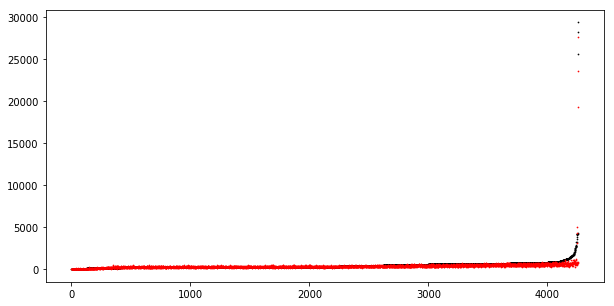

,browse_count_true,browse_count_pred
0,271,272.936371
1,256,259.646454
2,849,720.042664
3,305,291.747192
4,208,259.776764
5,222,237.322327
6,209,217.769241
7,342,271.587341
8,67,37.776466
9,254,249.315750


In [31]:
from sklearn.metrics import mean_squared_error
def getdiff(model, valid=True):
    df = pd.DataFrame(dvalid['browse_count'].values, columns=['browse_count_true'])
    df['browse_count_pred'] = (model.predict(X_valid))
    return df

df_diff = getdiff(model)
mse =  mean_squared_error(df_diff['browse_count_true'].values, df_diff['browse_count_pred'].values)
print(mse)

# Plot outputs
mpl.rcParams['figure.figsize'] = 10, 5
df_diff_sorted = df_diff.sort_values('browse_count_true')
plt.scatter(range(len(df_diff_sorted)), df_diff_sorted['browse_count_true'].values, color='black', s=0.5)
plt.scatter(range(len(df_diff_sorted)), df_diff_sorted['browse_count_pred'].values, color='red', s=0.5)

plt.show()
df_diff

In [78]:
# # for testing
# from string import punctuation
# np.save('le_group.npy', le_group.classes_)
# np.save('le_corpus_day.npy', le_corpus_day.classes_)
# with open('term_idx_mapping.json', 'w', encoding='utf8') as f:
#     json.dump(term_idx_mapping, f)
# with open('max_corpus_day', 'w', encoding='utf8') as f:
#     f.write(str(max_corpus_day))

# nowtime = str(datetime.now())
# for p in punctuation:
#     nowtime = nowtime.replace(p, '')
# filetime = nowtime[:13]
# model.save(filetime + '.model')

# Predict

In [1]:
import requests
from bs4 import BeautifulSoup
import re

import os
import pandas as pd
import jieba
jieba.set_dictionary('dict.txt.big')
with open('stops.txt', 'r', encoding='utf8') as f:
    stops = f.read().split('\n')
    
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from datetime import datetime

In [2]:
def get_article_data(url):
    if not url.startswith("https://ithelp.ithome.com.tw/articles/"):
        assert "請給ithome文章的網址"
        
    row = {}
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'lxml')

    ## group
    group = soup.select(".qa-header")[0].find_all('a')[0].text.replace(' ', '').replace('\n', '')

    ## linke count
    like_count = int(soup.select('.likeGroup__num')[0].text)  ## 定位讚的次數

    ## article header
    header = soup.select('.qa-header')[0]
    corpusinfo = header.select('h3')[0].text.replace(' ', '').replace('\n', '')
    corpus_title = corpusinfo.split('第')[0]  ## 定位文章集的的主題
    corpus_day = int(re.findall(r'第[\d]+篇', corpusinfo)[0].replace('第', '').replace('篇', ''))  ## 定位參賽第幾天

    article_title = header.select('h2')[0].text.replace(' ', '').replace('\n', '')  ## 定位文章的title
    writer_name = header.select('.ir-article-info__name')[0].text.replace(' ', '').replace('\n', '')  ## 定位作者名稱
    writer_url = header.select('.ir-article-info__name')[0]['href']  ## 定位作者的個人資訊業面

    publish_date_str = header.select('.qa-header__info-time')[0]['title']  ## 定位發文日期，為了讓日期的格式被讀成python的datetime，所以做了下面很瑣碎的事
    date_items = pd.Series(publish_date_str.split(' ')[0].split('-') + publish_date_str.split(' ')[1].split(':')).astype(int)
    publish_datetime = datetime(date_items[0], date_items[1], date_items[2], date_items[3], date_items[4], date_items[5])

    browse_count = int(re.findall(r'[\d]+', header.select('.ir-article-info__view')[0].text)[0])  ## 定位瀏覽次數

    ## markdown_html
    markdown_html = soup.select('.markdown__style')[0]
    text_content = "\n".join([p.text for p in markdown_html.select('p')])  ## 定位所有文章的段落，這邊我懶得爬讀片跟程式碼了
    h1 = [h1.text for h1 in markdown_html.select('h1')]  ## 定位文章的標題們
    h2 = [h2.text for h2 in markdown_html.select('h2')] 
    h3 = [h3.text for h3 in markdown_html.select('h3')]
    h4 = [h4.text for h4 in markdown_html.select('h4')]
    h5 = [h5.text for h5 in markdown_html.select('h5')]
    h6 = [h6.text for h6 in markdown_html.select('h6')]

    row['group'] = group
    row['like_count'] = like_count
    row['corpus_title'] = corpus_title
    row['corpus_day'] = corpus_day
    row['article_title'] = article_title
    row['writer_name'] = writer_name
    row['writer_url'] = writer_url
    row['publish_datetime'] = publish_datetime
    row['browse_count'] = browse_count

    row['text_content'] = text_content
    row['h1'] = h1 if h1 != [] else None
    row['h2'] = h2 if h2 != [] else None
    row['h3'] = h3 if h3 != [] else None
    row['h4'] = h4 if h4 != [] else None
    row['h5'] = h5 if h5 != [] else None
    row['h6'] = h6 if h6 != [] else None

    row['crawled_date'] = datetime.now()
    
    return row

In [3]:
le_group = LabelEncoder()
le_group.classes_ = np.load('le_group.npy')
le_corpus_day = LabelEncoder()
le_corpus_day.classes_ = np.load('le_corpus_day.npy')    
with open('term_idx_mapping.json', 'r', encoding='utf8') as f:
    term_idx_mapping = json.load(f)
with open('max_corpus_day', 'r', encoding='utf8') as f:
    max_corpus_day = int(f.read())
def preprocess(df):
    df.fillna('None', inplace=True)
    df[df['corpus_day'] > max_corpus_day] = max_corpus_day  ## for testing purpose

    def preprocess_applyfun(row):
        # combine all headers
        header = ""
        for h in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
            if row[h] != "None":
                header += " ".join(row[h]) + "\n"

        # Tokenize
        row['article_title'] = [w for w in jieba.cut(row['article_title'], cut_all=True)]
        row['corpus_title'] = [w for w in jieba.cut(row['corpus_title'], cut_all=True)]
        row['header'] = [w for w in jieba.cut(header, cut_all=True)]
        row['text_content'] = [w for w in jieba.cut(row['text_content'], cut_all=True) if w not in stops]
        # cal_publish_hours
#         timedelta = row['crawled_date'] - row['publish_datetime']
#         row['publish_hours'] = timedelta.days * 24 + timedelta.seconds // 3600
        # group and corpus_day categorilize
        row['group'] = le_group.transform([row['group']])[0]
        row['corpus_day'] = le_corpus_day.transform([row['corpus_day']])[0]

        return row
    df = df.apply(preprocess_applyfun, axis=1)
            
    # Serialize tokens
    def getidxs(terms):
        idxs = []
        for term in terms:
            if term in term_idx_mapping.keys():
                idx = term_idx_mapping.get(term)
                idxs.append(idx)
        return idxs
    df['article_title'] = df['article_title'].apply(getidxs)
    df['corpus_title'] = df['corpus_title'].apply(getidxs)
    df['header'] = df['header'].apply(getidxs)
    df['text_content'] = df['text_content'].apply(getidxs)
    return df

In [4]:
from keras.models import load_model
# model = load_model("20180105 1248.model")
model = load_model("20180105 2149.model")

MAX_ARTICLE_TITLE_SEQ = 60 #60
MAX_CORPUS_TITLE_SEQ = 20 #22
MAX_HEADER_SEQ = 250 #260
MAX_TEXT_CONTENT_SEQ = 500 #1195

Using TensorFlow backend.


In [5]:
url = "https://ithelp.ithome.com.tw/articles/10195707"
data = get_article_data(url)
df_test = pd.DataFrame([data] * 10)
for i in range(len(df_test)):
    df_test.loc[i, 'publish_hours'] = 24 * (i+1)
df_test = preprocess(df_test)

df_test[['group', 'corpus_title', 'corpus_day', 'article_title', 'browse_count',
     'text_content', 'header', 'publish_hours']]

Building prefix dict from D:\Projects\ithome_ironman\day30_ithome_articles_pred\dict.txt.big ...
Loading model from cache C:\Users\Jeremy\AppData\Local\Temp\jieba.u611bbb79df8f1b83d7be7dc714cf7403.cache
Loading model cost 1.450 seconds.
Prefix dict has been built succesfully.


,group,corpus_title,corpus_day,article_title,browse_count,text_content,header,publish_hours
0,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",24.0
1,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",48.0
2,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",72.0
3,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",96.0
4,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",120.0
5,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",144.0
6,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",168.0
7,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",192.0
8,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",216.0
9,5,"[33649, 36047, 4850, 36863, 0, 0, 65447, 62827...",15,"[57521, 5199, 43273, 0, 0, 62009, 36572, 36047...",321,"[14852, 48868, 65010, 54911, 1, 39529, 42677, ...","[40627, 54317, 54911, 0, 0, 40627, 54317, 6501...",240.0


In [6]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences
def get_keras_data(dataset):
    X = {
        "seq_article_title":pad_sequences(dataset['article_title'], maxlen=MAX_ARTICLE_TITLE_SEQ),
        "seq_corpus_title":pad_sequences(dataset['corpus_title'], maxlen=MAX_CORPUS_TITLE_SEQ),
        "seq_header":pad_sequences(dataset['header'], maxlen=MAX_HEADER_SEQ),
        "seq_text_content":pad_sequences(dataset['text_content'], maxlen=MAX_TEXT_CONTENT_SEQ),
        'group': np.array(dataset['group']),
        'corpus_day': np.array(dataset['corpus_day']),
        'publish_hours': np.array(dataset['publish_hours']),
    }
    return X

X_test = get_keras_data(df_test)

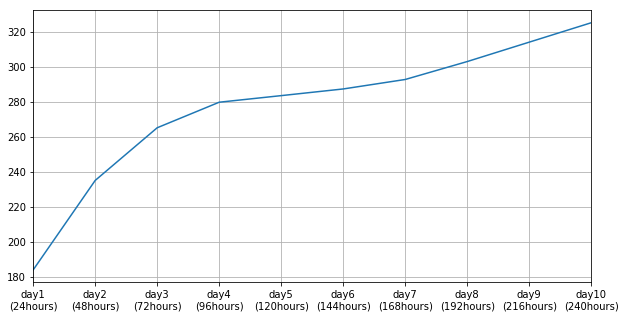

,day1 (24hours),day2 (48hours),day3 (72hours),day4 (96hours),day5 (120hours),day6 (144hours),day7 (168hours),day8 (192hours),day9 (216hours),day10 (240hours)
第15天-說好來介紹-OPENCART可以接那些金流物流,183,234,265,279,283,287,292,302,314,325


In [7]:
predict_result = model.predict(X_test)
mpl.rcParams['figure.figsize'] = 10, 5
df_pred = pd.DataFrame(predict_result, index=['day'+str(i)+'\n('+ str(i*24) +'hours)' for i in range(1,11)], columns=[data['article_title']])
ax = df_pred.plot(kind='line', legend=False, figsize=(10, 5), grid=True)
plt.show()
df_pred.astype(int).T